---
layout: post
title:  "Which Big City has the best Weather?"
desc: "Python Plotting Preferred Weather"
date: ###DATE
categories: [tutorial]
tags: [plotting]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/usweather"

---

Like many people, I might one day be moving to the United States for work. However, I would like to know where I should move too. Where is too hot? Where is it too wet? Where is my little slice of paradise??

So using the [NOAA Global Summary of the Day](https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00516) and the [top 25 most populated cities in the US](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population), we've got enough to make a plot.

But first, we have to smack this data format into something useable.

## Data preparation

I downloaded the data from 2020-2013, and extract the list of a billion csv files into a directory per year. Ouch. We're going to have to pre-process this. Let's load in the list of cities first from `cities.csv`. [You can download that file here.](/static/notebooks/us_weather/cities.csv)



In [284]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmasher as cmr
from pathlib import Path


root = Path("D:/data/weather/")

cities = pd.read_csv(root / "cities.csv")
cities.head()

,name,lat,long
0,New York,40.6635,-73.9387
1,Los Angeles,34.0194,-118.4108
2,Chicago,41.8376,-87.6818
3,Houston,29.7866,-95.3909
4,Phoenix,33.5722,-112.0901


Then, lets find all the csv files for the US states and load them in.

Great. Now lets open one of the weather files as an example:

In [292]:
pd.read_csv(data_root / "2020/71076099999.csv").describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
STATION,7.107610e+10,0.000000e+00,7.107610e+10,7.107610e+10
LATITUDE,5.956667e+01,1.282585e-13,5.956667e+01,5.956667e+01
LONGITUDE,-1.084833e+02,4.275283e-14,-1.084833e+02,-1.084833e+02
ELEVATION,3.180000e+02,0.000000e+00,3.180000e+02,3.180000e+02
TEMP,1.806011e+01,2.669257e+01,-3.280000e+01,6.630000e+01
TEMP_ATTRIBUTES,2.366854e+01,1.440817e+00,1.000000e+01,2.400000e+01
DEWP,7.848315e+00,2.382630e+01,-4.060000e+01,4.990000e+01
DEWP_ATTRIBUTES,2.361236e+01,1.461856e+00,1.000000e+01,2.400000e+01
SLP,1.017151e+03,1.084217e+01,9.926000e+02,1.048300e+03
SLP_ATTRIBUTES,2.366854e+01,1.440817e+00,1.000000e+01,2.400000e+01


Alright, so we have one csv file per year, per station. And what we'd want to do is match stations within a certain lat/long distance to the city coordinate. Oh boy, this is going to take a while to run. 

Let's write up something that goes through and just extracts station, lat, long, and then filters down to the stations we want. Im only going to use stations from 2020 (but they'll have data from other years).

In [68]:
station_locations = root / "station_locations.csv"

# If Ive done this before, load in the previous results
if os.path.exists(station_locations):
    station_df = pd.read_csv(station_locations)
    
# Or else figure it out from scratch using 2020 year
else:
    stations = {}
    y = "2020"
    for f in os.listdir(root / y):
        path = root / y / f
        res = pd.read_csv(path, nrows=1, usecols=["STATION", "LATITUDE", "LONGITUDE"])
        stations[f.replace(".csv", "")] = res
    station_df = pd.concat(list(stations.values()))
    station_df.columns = ["station", "lat", "long"]
    station_df.to_csv(station_locations, index=False)

Wow that took a long time to run. Lets save it out so we don't have to do that again. And then Im going to edit the code above to check that the `station_location.csv` doesn't exist, so this doesn't run whenever I start this notebook up.

In [69]:
# Checking everything looks alright
station_df.head()

,station,lat,long
0,1001099999,70.933333,-8.666667
1,1001499999,59.791925,5.340850
2,1002099999,80.050000,16.250000
3,1003099999,77.000000,15.500000
4,1006099999,78.250000,22.816667


Okay, first issue down. Now what we can do is filter that list to determine which stations are in the cities we care about. So we want a method to map a station to a city, if it is close enough

In [70]:
def check_station(row, threshold=0.05):
    station, lat, long, *_ = row
    found = False
    distance = (cities.lat - lat)**2 + (cities.long - long)**2
    matches = distance < threshold
    if matches.sum():
        return cities[matches].name.iloc[0]
    else:
        return np.NaN
    
# Lets test this works, we should get New York out
check_station(("New York", 40.6, -73.9))

'New York'

Fantastic. Now lets run it over all stations:

In [71]:
station_df["city"] = station_df.apply(check_station, axis=1)
final_stations = station_df.set_index("station").dropna()
final_stations.head()

,lat,long,city
station,,,
71538099999,42.275556,-82.955556,Detroit
72011354829,42.543060,-83.178060,Detroit
72030464752,40.100000,-75.266670,Philadelphia
72055399999,40.701214,-74.009028,New York
72059400188,29.717000,-95.383000,Houston


Great, so we've got matching weather stations now. In fact, we have 91 of them! Now for the super slow part. For each of these stations, I want to go through and load in the csv files for all available years, keeping the city information preserved.

In [219]:
years = [y for y in os.listdir(root) if os.path.isdir(root / y)]
cols = ["STATION", "DATE", "MAX", "WDSP", "PRCP"]

df_name = root / "weather.csv"

if os.path.exists(df_name):
    df_weather = pd.read_csv(df_name)
else:
    dfs = []
    for y in years:
        for f in os.listdir(root / y):
            station = int(f.replace(".csv", ""))
            if station in final_stations.index:
                df = pd.read_csv(root / y / f, usecols=cols, parse_dates=["DATE"])
                df["city"] = final_stations.loc[station, "city"]
                dfs.append(df)
    df_weather = pd.concat(dfs).reset_index(drop=True)
    df_weather.to_csv(df_name, index=False)
    
df_weather    

,STATION,DATE,WDSP,MAX,PRCP,city
0,71538099999,2013-01-01,7.3,34.2,0.0,Detroit
1,71538099999,2013-01-02,5.8,30.2,0.0,Detroit
2,71538099999,2013-01-03,10.0,28.4,0.0,Detroit
3,71538099999,2013-01-04,14.8,30.2,0.0,Detroit
4,71538099999,2013-01-05,9.5,30.2,0.0,Detroit
...,...,...,...,...,...,...
225441,99849999999,2020-06-26,3.3,78.6,0.0,Chicago
225442,99849999999,2020-06-27,4.8,84.7,0.0,Chicago
225443,99849999999,2020-06-28,3.1,84.9,0.0,Chicago
225444,99849999999,2020-06-29,2.9,79.9,0.0,Chicago


Alright, now we're getting somewhere, 225k rows! Except, oh boy, I can see that 999 is being used as a NaN value. Lets fix that up.

In [225]:
# Yes it has all three variants -_-
df_weather = df_weather.replace(999.9, np.NaN).replace(99.99, np.NaN).replace(9999.9, np.NaN)
df_weather

,STATION,DATE,WDSP,MAX,PRCP,city
0,71538099999,2013-01-01,7.3,34.2,0.0,Detroit
1,71538099999,2013-01-02,5.8,30.2,0.0,Detroit
2,71538099999,2013-01-03,10.0,28.4,0.0,Detroit
3,71538099999,2013-01-04,14.8,30.2,0.0,Detroit
4,71538099999,2013-01-05,9.5,30.2,0.0,Detroit
...,...,...,...,...,...,...
225441,99849999999,2020-06-26,3.3,78.6,0.0,Chicago
225442,99849999999,2020-06-27,4.8,84.7,0.0,Chicago
225443,99849999999,2020-06-28,3.1,84.9,0.0,Chicago
225444,99849999999,2020-06-29,2.9,79.9,0.0,Chicago


## Data engineering

The distinction here is that - at this point - we have a viable dataset which we can now manipulate as we see fit. We can create features and play around, but we have *right here* as a checkpoint. What I want to do is create a few **features** to determine what I would consider a good or bad day is. I'll be simple, and break this into **temperature** and **weather** features. And note that - as I don't really care what temperature it is during the night, I'll use the max temperature for everything.

I want to define two sliding scales, between -1 and 1, where -1 is a horrible cold day, and 1 is a horrible hot day. Aka hot and bad weather, or cold and bad weather. This is obviously **entirely** subjective, but what I'll do is this:

* "Cold" becomes normalised between -10C to 15C (14F to 59F)
* "Hot" becomes normalised between 28C to 38C (83F to 100F)
* Precipitation (in inches) is normalised between 0 and 1.5
* Wind (in knots) is normalised between 0 and 20
* Weather is the maximum between precipiation and wind

We can see the distributions here:

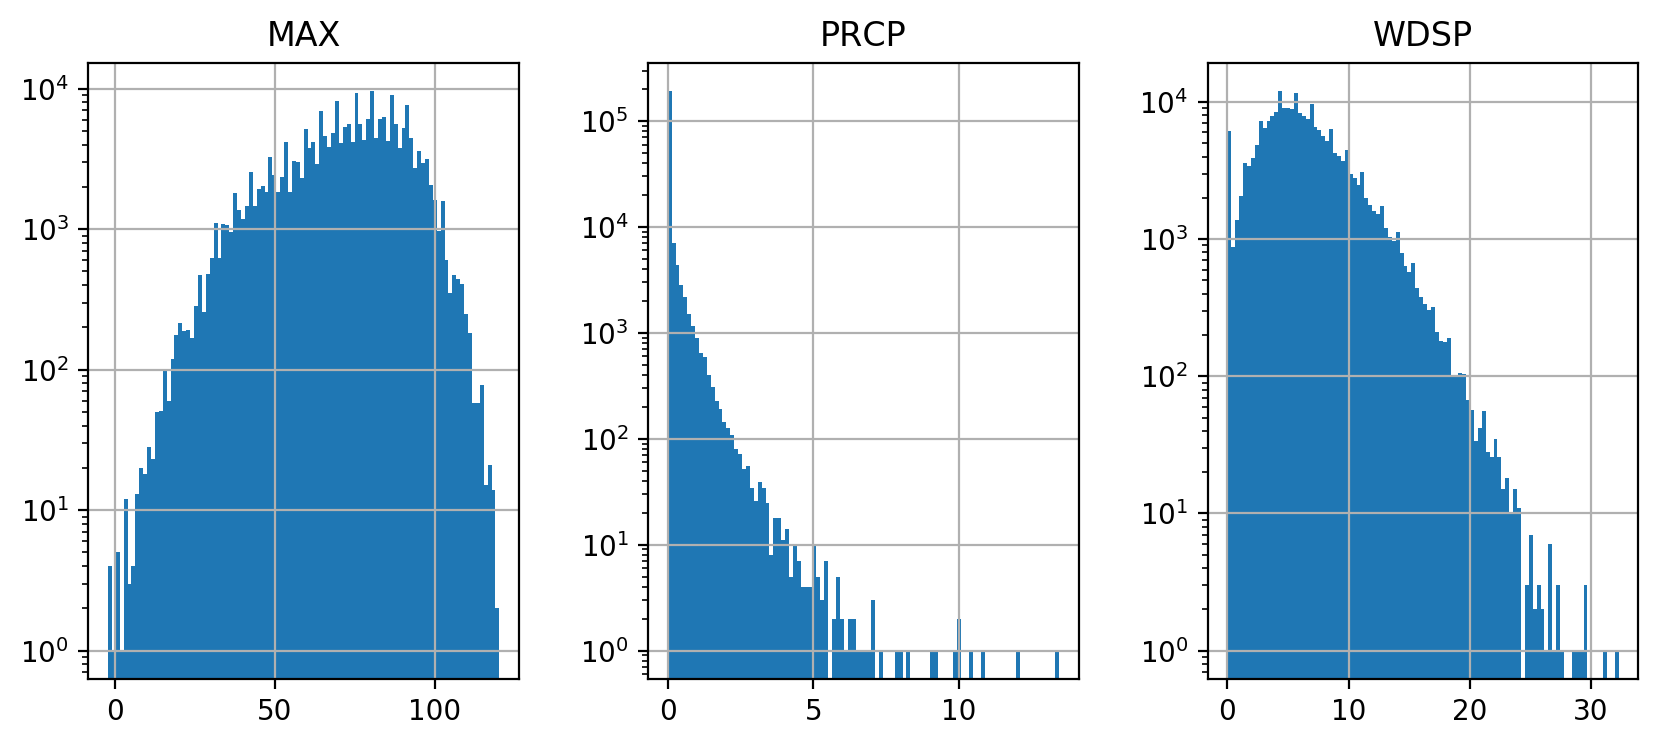

In [227]:
df_weather[["MAX", "PRCP", "WDSP"]].hist(bins=100, log=True, layout=(1, 3), figsize=(10, 4));

So let's add in that feature:

In [234]:
from sklearn.preprocessing import minmax_scale

df_weather["cold"] = minmax_scale(df_weather.MAX.clip(14, 59), (-1, 0))
df_weather["hot"] = minmax_scale(df_weather.MAX.clip(83, 100), (0, 1))
df_weather["rating_precip"] = minmax_scale(df_weather.PRCP.clip(0, 1.5), (0, 1))
df_weather["rating_wind"] = minmax_scale(df_weather.PRCP.clip(0, 20), (0, 1))

# Combine the weather and temp ratings
df_weather["rating_weather"] = df_weather[["rating_precip", "rating_wind"]].max(axis=1)
df_weather["rating_temp"] = df_weather.cold + df_weather.hot + 0.001

# Make some little feature to represent our total rating
df_weather["rating"] = np.sign(df_weather.rating_temp) * df_weather.rating_weather + df_weather.rating_temp
df_weather["rating"] = minmax_scale(df_weather["rating"].clip(-1, 1))

D:\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


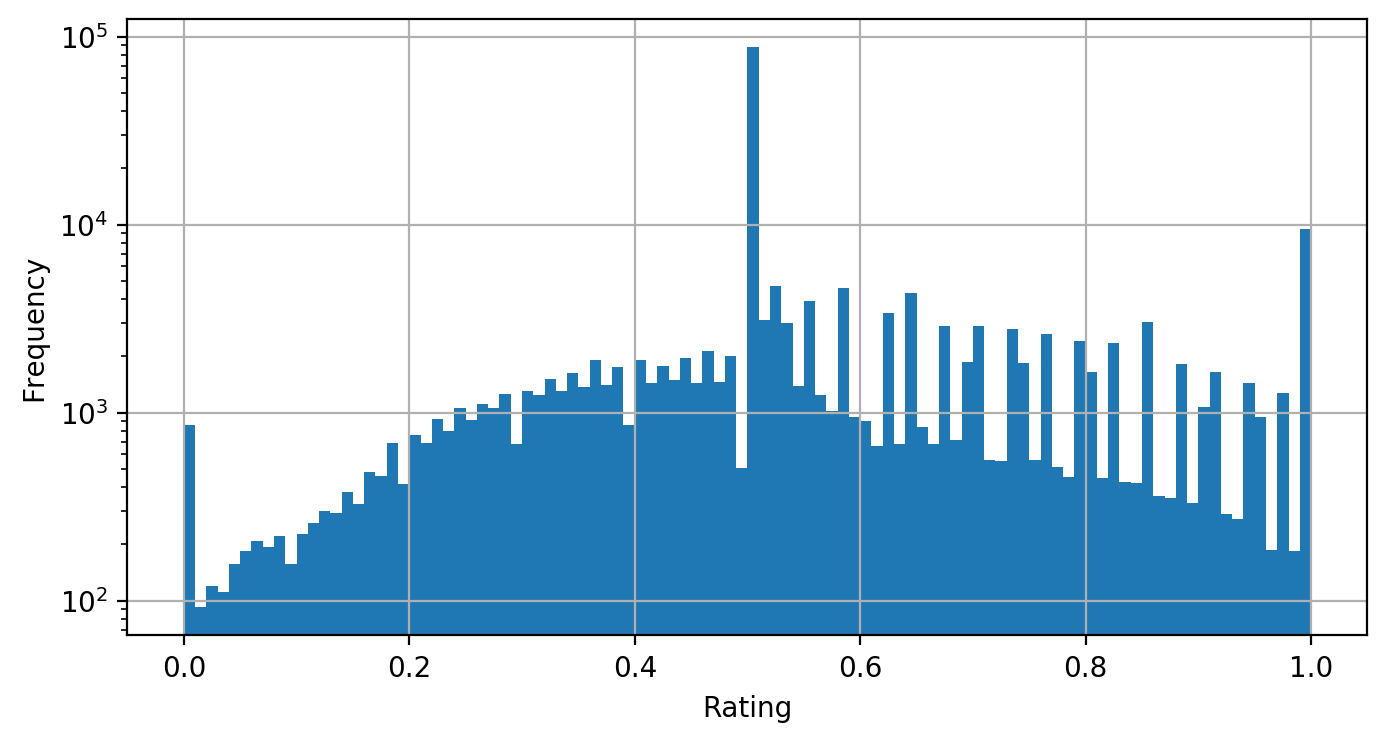

In [294]:
ax = df_weather["rating"].hist(bins=100, log=True, figsize=(8, 4))
ax.set_xlabel("Rating"), ax.set_ylabel("Frequency");

Obiously **this is all completely dependent on arbitrary choices on weather**. Let's not get caught up on that. We can come back to this feature later if we need. For now, we want to take all the datapoints we have and take the average for each day in the year.

In [236]:
df_weather["day"] = df_weather.DATE.dt.dayofyear
df = df_weather.groupby(["city", "day"]).rating.mean().reset_index()
df

,city,day,rating
0,Austin,1,0.417907
1,Austin,2,0.374362
2,Austin,3,0.441442
3,Austin,4,0.473205
4,Austin,5,0.475186
...,...,...,...
8779,Washington,362,0.435083
8780,Washington,363,0.404806
8781,Washington,364,0.369343
8782,Washington,365,0.348139


## Make the plot

Again we're going to run into the issue that we've compressed two axes (temp and weather) down into one. Ah well, I'm not going to publish this anyway!

First thing is I'll just sort cities based on their average rating, and pick a colorset. I'm going to use a colormap from `cmasher` because I think it look great.

In [278]:
city_order = df.groupby("city").rating.mean().sort_values(ascending=False)
cmap = plt.get_cmap('cmr.fusion_r')

And then away we go plotting!

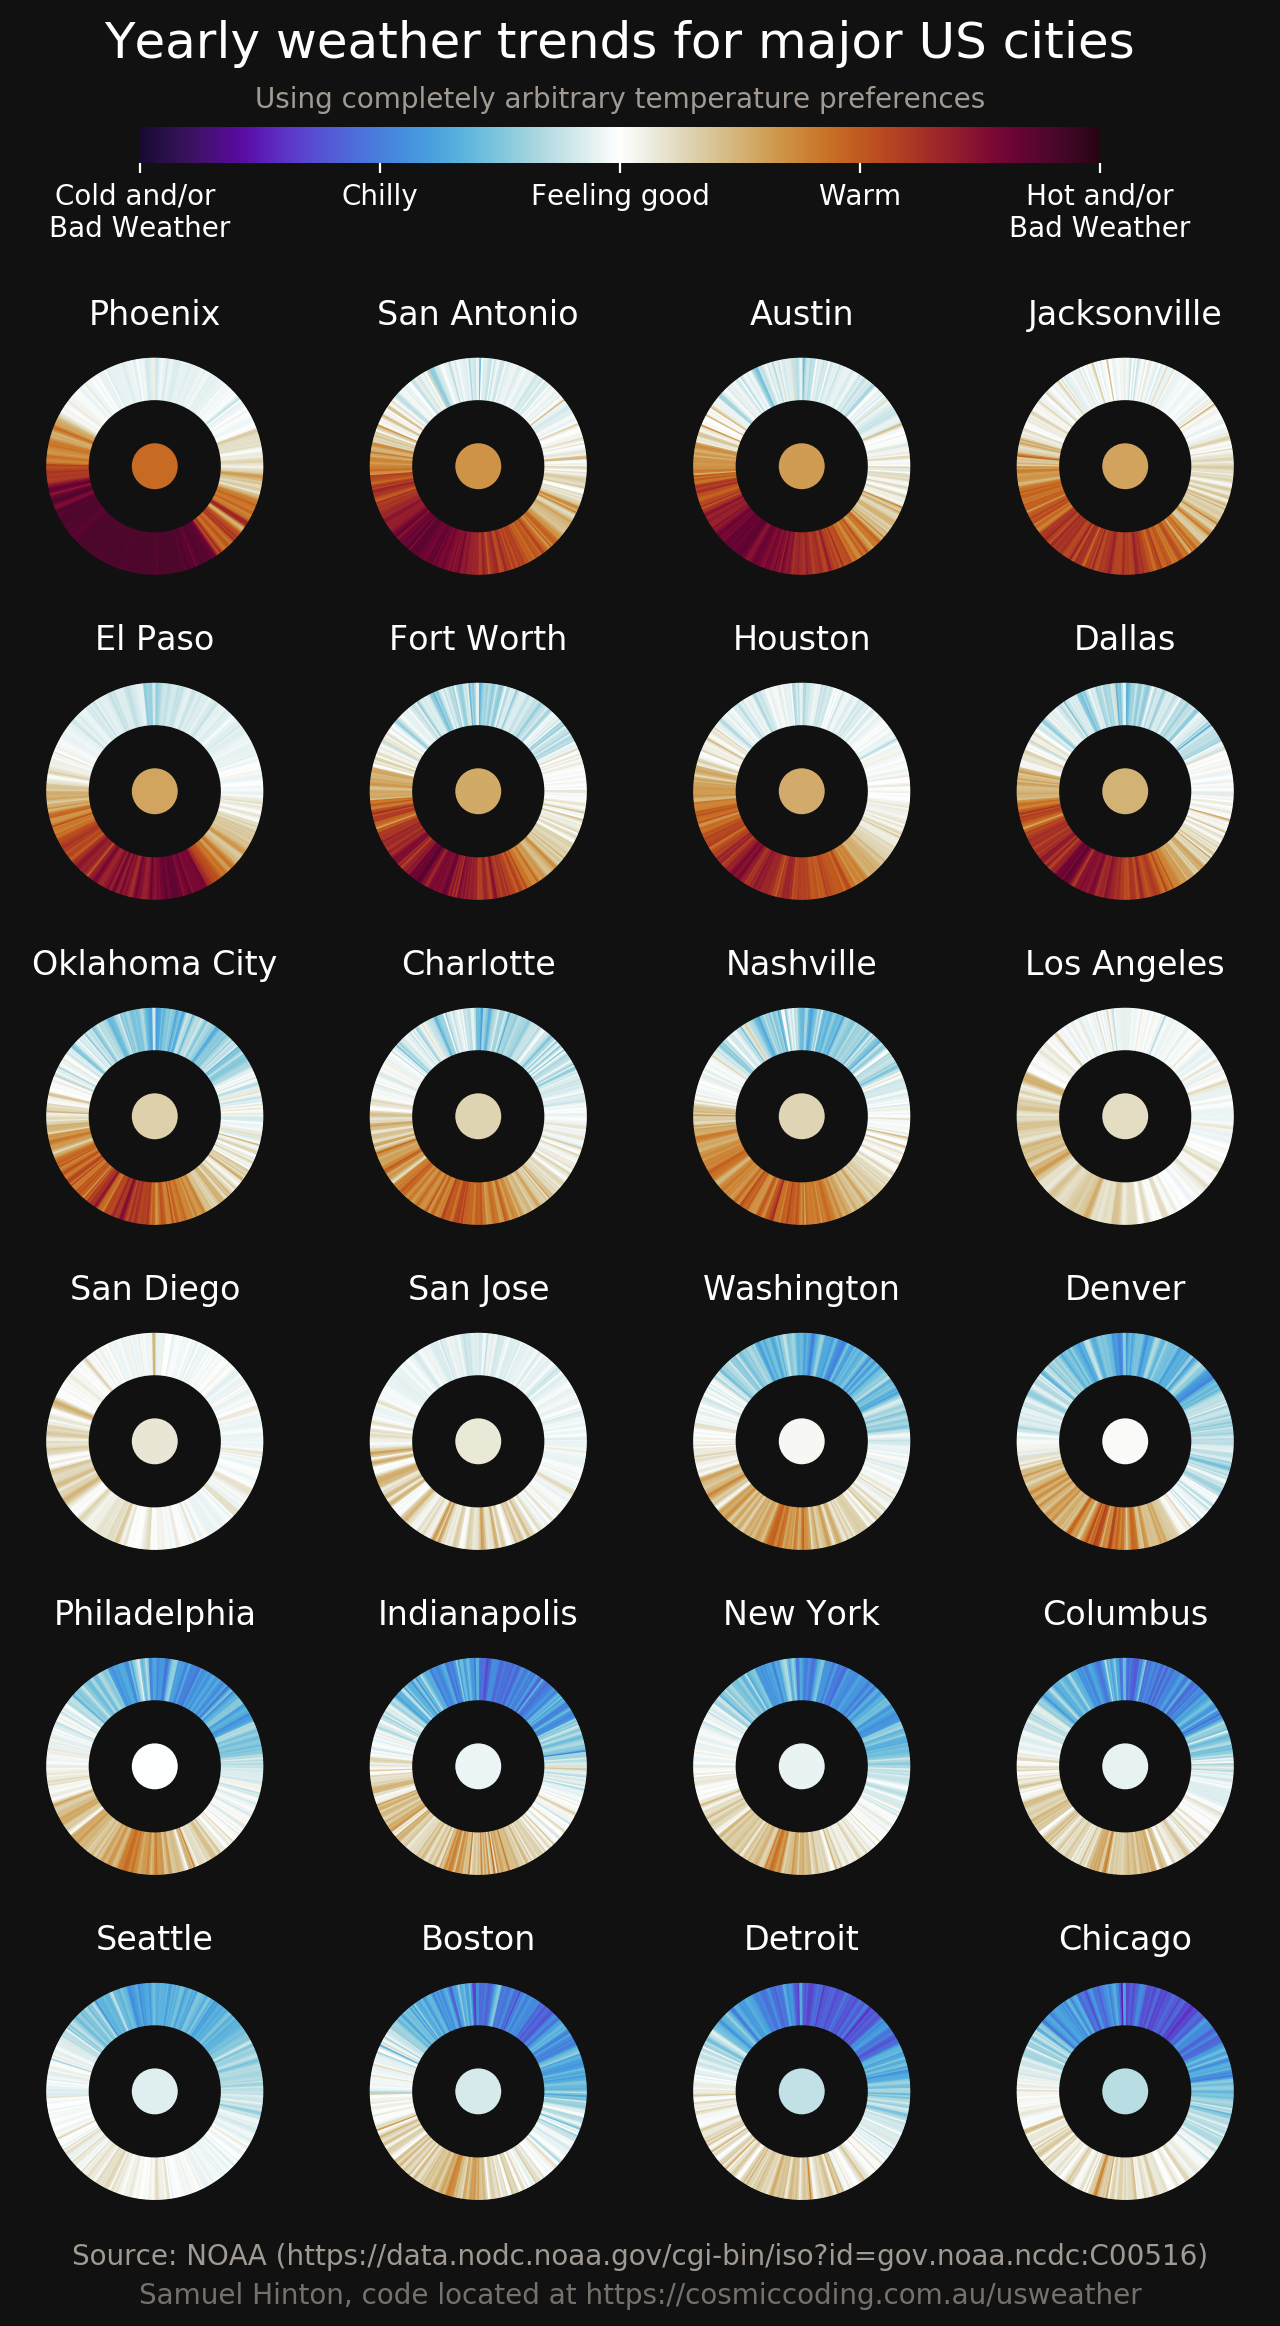

In [299]:
# Get a nice dark figure
bg = "#111111"
plt.style.use("dark_background")
fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(8, 12))
fig.patch.set_facecolor(bg)

# Make donut plots
for (city, avg), ax in zip(city_order.iteritems(), axes.flatten()):
    df_tmp = df[df.city == city]
    xs = np.ones(df_tmp.shape[0])
    colors = [cmap(0.95 * r) for r in df_tmp.rating]
    ws, ts = ax.pie(xs, colors=colors, counterclock=False, startangle=90)
    # Set the line for each wedge to stop artifacts
    for w, c in zip(ws, colors):
        w.set_linewidth(0.5)
        w.set_edgecolor(c)
        
    ax.set_title(city, pad=-2)
    ax.set_aspect('equal', 'box')
    ax.add_artist(plt.Circle((0, 0), .6, color=bg))
    
    # Add average rating color circle
    ax.add_artist(plt.Circle((0, 0), .2, color=cmap(avg)))


# Add the custom colorbar
fig.subplots_adjust(top=0.83, bottom=0.04)
cbar_ax = fig.add_axes([0.2, 0.9, 0.6, 0.015])
cbar_ax.set_title("Yearly weather trends for major US cities", pad=25, fontsize=18)
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, orientation='horizontal', 
                               ticks=[0, 0.25, 0.5, 0.75, 1])
cb.outline.set_visible(False)
cb.ax.set_xticklabels(["Cold and/or \nBad Weather", "Chilly", "Feeling good", "Warm", "Hot and/or\nBad Weather"]);

# And add our annotations
plt.annotate('Using completely arbitrary temperature preferences', 
                    (0.5,1), (0, 15), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
plt.annotate('Source: NOAA (https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00516)', 
                    (0.5,0.024), (0, 0), xycoords='figure fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='bottom', ha="center")
plt.annotate('Samuel Hinton, code located at https://cosmiccoding.com.au/usweather', (0.5,0.007), (0, 0), xycoords='figure fraction', color="#a19a92", textcoords='offset points', size=10, va='bottom', ha="center", alpha=0.7) ###REMOVE
fig.savefig("us_weather/weather.png", dpi=200, bbox_inches="tight", pad_inches=0.3, facecolor=fig.get_facecolor()) ###REMOVE
plt.style.use("default") ###REMOVE


!!! poster

There we go! Its not perfect, but I think it's pretty, and certainly San Jose is looking like a real nice place to go! And lets not go live in Phoenix. I don't know if its just stupidly hot or theres bad weather as well (a failing of the plot I admit), either way - nope.

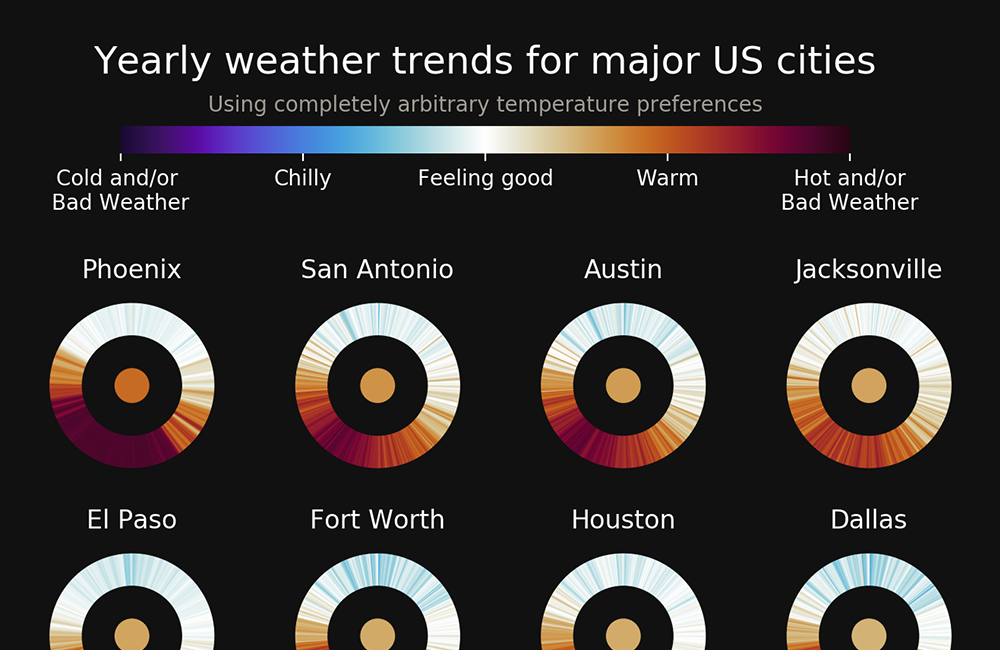

In [289]:
from IPython.display import Image
Image("us_weather/cover.png")

!!!main remove_main